In [1]:
%run ~/relmapping/annot/notebooks/__init__.ipynb

/mnt/home3/jj374/anaconda36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


os.getcwd(): /mnt/beegfs/scratch_copy/ahringer/jj374/lab/relmapping


In [2]:
df_sites = pd.read_csv('annot/Fig1D1_accessible_sites/Fig1D1_accessible_sites.tsv', sep='\t')
print('%s accessible sites' % (yp.f_uk(len(df_sites)),))
df_sites.head()

42,245 accessible sites


,chrom,start,end,atac_peak_accessibility,atac_source,atac_wt_emb_height,atac_wt_l1_height,atac_wt_l2_height,atac_wt_l3_height,atac_wt_l4_height,atac_wt_ya_height,atac_glp1_d1_height,atac_glp1_d2_height,atac_glp1_d6_height,atac_glp1_d9_height,atac_glp1_d13_height
0,chrI,1900,2051,1975,atac_wt_se,1.487219,1.436852,1.234831,1.476625,1.180041,3.028015,0.984149,0.912876,1.155934,1.187989,1.661203
1,chrI,3826,3977,3901,atac_wt_pe,67.202148,58.451061,74.416000,133.738358,179.794342,211.372787,88.025909,69.674324,68.506355,64.593590,55.413097
2,chrI,4276,4427,4351,atac_wt_se,1.581892,2.656172,2.186598,3.502825,5.871352,7.771934,1.802739,1.327403,1.547550,2.069787,1.901336
3,chrI,11272,11423,11347,atac_wt_pe,2.606371,4.443353,9.830266,10.700469,11.683004,13.928377,20.864365,16.739265,17.585819,15.858321,17.019400
4,chrI,13070,13221,13145,atac_wt_pe,5.557951,3.608833,3.977978,3.398183,2.689872,2.953438,2.047788,2.084701,1.994170,2.586042,3.367910


In [3]:
def scap_count_fwd(sample):
    df_sites = pd.read_csv('annot/Fig1D1_accessible_sites/Fig1D1_accessible_sites.tsv', sep='\t')[yp.NAMES_BED3]
    step_fwd = 'tg_se.bwa_se.rm_unmapped.rm_chrM.rm_blacklist.rm_q10.firstbp_fwd'
    fp = pf('scap815_' + sample, step_fwd, '.bw', 'scap815')
    df_sites['%(sample)s' % locals()] = list(map(lambda c: int(np.nansum(c)),
            yp.read_regions(fp, df_sites.chrom.tolist(), df_sites.start.tolist(), df_sites.end.tolist())))
    return df_sites

def scap_count_rev(sample):
    df_sites = pd.read_csv('annot/Fig1D1_accessible_sites/Fig1D1_accessible_sites.tsv', sep='\t')[yp.NAMES_BED3]
    step_rev = 'tg_se.bwa_se.rm_unmapped.rm_chrM.rm_blacklist.rm_q10.firstbp_rev'
    fp = pf('scap815_' + sample, step_rev, '.bw', 'scap815')
    df_sites['%(sample)s' % locals()] = list(map(lambda c: int(np.nansum(c)),
            yp.read_regions(fp, df_sites.chrom.tolist(), df_sites.start.tolist(), df_sites.end.tolist())))
    return df_sites

l_df_fwd = pmap(scap_count_fwd, config['stages_wt_rep_scap815'], n_jobs=16)
l_df_rev = pmap(scap_count_rev, config['stages_wt_rep_scap815'], n_jobs=16)

df_scap_fwd = reduce(lambda l, r: pd.merge(l, r, on = yp.NAMES_BED3), l_df_fwd)
df_scap_rev = reduce(lambda l, r: pd.merge(l, r, on = yp.NAMES_BED3), l_df_rev)

df_scap_fwd['strand'] = '+'
df_scap_rev['strand'] = '-'

#df_scap = pd.concat([df_scap_fwd, df_scap_rev], axis=0) # strands separately
df_scap = df_scap_fwd + df_scap_rev # sum across strands
df_scap.head()

[Parallel(n_jobs=16)]: Done  14 out of  14 | elapsed:   12.3s finished
[Parallel(n_jobs=16)]: Done  14 out of  14 | elapsed:   12.1s finished


,chrom,start,end,wt_emb_rep1,wt_emb_rep2,wt_emb_rep3,wt_emb_rep4,wt_l1_rep1,wt_l1_rep2,wt_l2_rep1,wt_l2_rep2,wt_l3_rep1,wt_l3_rep2,wt_l4_rep1,wt_l4_rep2,wt_ya_rep1,wt_ya_rep2,strand
0,chrIchrI,3800,4102,39,13,7,4,10,1,0,0,0,0,0,0,1,1,+-
1,chrIchrI,7652,7954,25909,29911,73130,97498,371006,14604,94259,112207,7105667,65544,28068,29984,1186162,74994,+-
2,chrIchrI,8552,8854,4,2,3,1,0,1,2,0,1,0,1,1,5,0,+-
3,chrIchrI,22544,22846,2,13,9,1,16,4,26,47,2,12,2,2,22,2,+-
4,chrIchrI,26140,26442,0,0,2,0,6,0,1,0,1,0,0,0,0,0,+-


42245 rows raw
25337 rows selected after removing low outliers


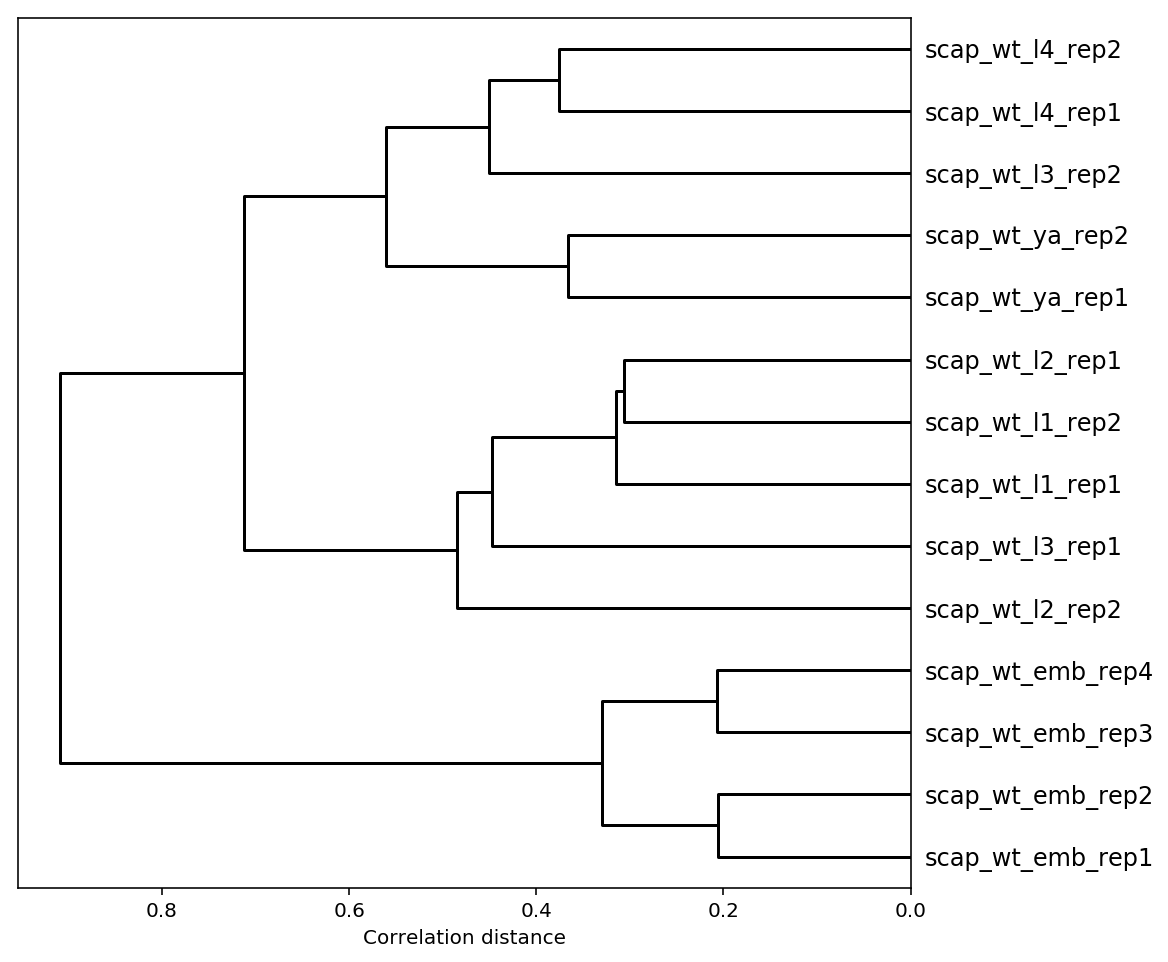

In [4]:
df_r_ = df_scap[[s for s in config['stages_wt_rep_scap815']]]
print(len(df_r_), 'rows raw')
df_r_ = df_r_.loc[10 < df_r_.max(axis=1)].reset_index(drop=True)
print('%d rows selected after removing low outliers' % (len(df_r_),))
#df_r_ = df_r_.loc[df_r_.sum(axis=1) < 250].reset_index(drop=True)
#print('%d rows selected after removing high outliers' % (len(df_r_),))
df_r_ = df_r_.rank(axis=0, ascending=True)

counts_ = df_r_.values.T
linkage_matrix = sp.cluster.hierarchy.linkage(counts_, metric='correlation', method='complete')
plt.figure(figsize=(8,8))
r=sp.cluster.hierarchy.dendrogram(linkage_matrix, labels=['scap_%s' % (s,) for s in config['stages_wt_rep_scap815']], orientation='left', 
                                  color_threshold=-1.0, above_threshold_color='k')
plt.gca().set_xlabel('Correlation distance')
plt.savefig('annot/FigA_clustering/reproducibility_scap.pdf', bbox_inches='tight')

In [5]:
df_ = collections.OrderedDict()
for stage_atac in itertools.islice(config['stages_wt'], None):
    df_[stage_atac] = collections.OrderedDict()
    for rep_scap in itertools.islice(config['stages_wt_rep_scap815'], None):
        #corr_ = sp.stats.spearmanr(
        #    df_sites['atac_%s_height' % (stage_atac,)],
        #    df_scap[rep_scap]
        #).correlation
        corr_ = sp.stats.kendalltau(
            df_sites['atac_%s_height' % (stage_atac,)],
            df_scap[rep_scap]
        ).correlation
        df_[stage_atac][rep_scap] = corr_

df_ct = pd.DataFrame.from_dict(df_, orient='columns')
df_ct

,wt_emb,wt_l1,wt_l2,wt_l3,wt_l4,wt_ya
wt_emb_rep1,0.431152,0.301237,0.263227,0.288400,0.284127,0.264536
wt_emb_rep2,0.393766,0.325986,0.304501,0.322499,0.300466,0.259085
wt_emb_rep3,0.425397,0.351645,0.342495,0.345192,0.319731,0.236435
wt_emb_rep4,0.369688,0.294962,0.278736,0.296633,0.280510,0.233166
wt_l1_rep1,0.194350,0.378924,0.352440,0.334304,0.305786,0.285348
wt_l1_rep2,0.239859,0.384737,0.360679,0.345290,0.315781,0.292072
wt_l2_rep1,0.166452,0.339880,0.362274,0.340885,0.314284,0.292116
wt_l2_rep2,0.195721,0.317912,0.337517,0.317080,0.285611,0.263317
wt_l3_rep1,0.153821,0.303205,0.321483,0.352216,0.336439,0.301756
wt_l3_rep2,0.161816,0.258760,0.252122,0.324613,0.323897,0.290920


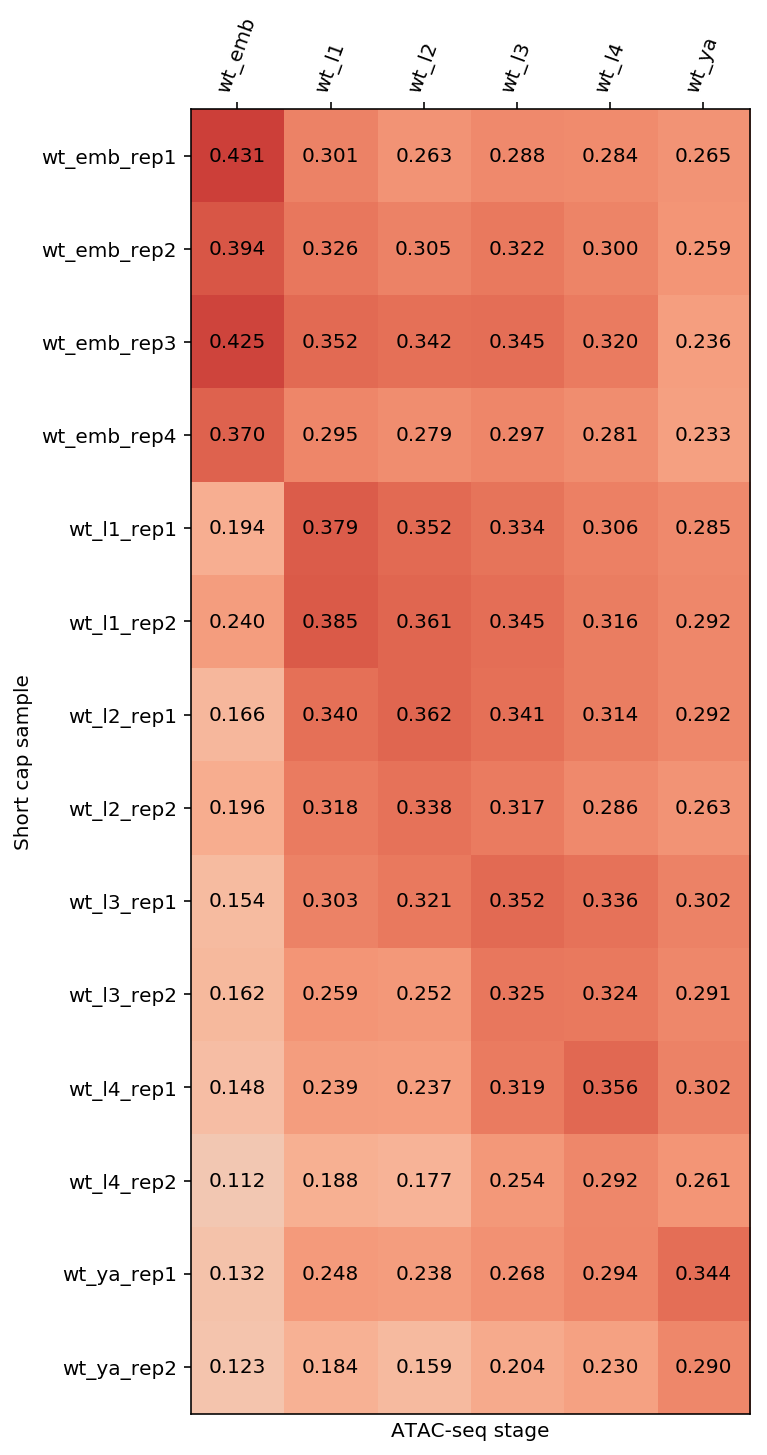

In [6]:
def df_imshow(df_, ax=None, row_labels=None, col_labels=None, vmin=-0.5, vmax=+0.5, rotation=70, *args, **kwargs):
    if ax is None: ax = plt.gca()
    if row_labels is None: row_labels = df_.index
    if col_labels is None: col_labels = df_.columns
    ax.imshow(df_, cmap='coolwarm', interpolation='nearest', vmin=vmin, vmax=vmax, *args, **kwargs)
    ax.xaxis.tick_top()
    ax.set_xticks(range(len(col_labels)))
    ax.set_yticks(range(len(row_labels)))
    ax.set_xticklabels(col_labels, rotation=rotation)
    ax.set_yticklabels(row_labels)
    for (y, x), c in np.ndenumerate(df_):
        ax.text(x, y, '%.3f' % (c,), color='k', horizontalalignment='center', verticalalignment='center')

fig = plt.figure(figsize=(12, 12))
plt.gca().set_xlabel('ATAC-seq stage')
plt.gca().set_ylabel('Short cap sample')
df_imshow(df_ct)
plt.savefig('annot/FigA_clustering/reproducibility_scap_vs_atac.pdf', bbox_inches='tight')